# 1. Wstęp:
Projekt ma na celu przeanalizowanie danych dotyczących meczów tenisowych z ostatnich 20 lat. Dane dotyczą rozgrywek zawodowych i pochodzą z turniejów każdej rangi (od wielkich szlemów przez turnieje ATP250 aż po niewielkie turnieje międzynarodowe). Plik z danymi został pobrany ze strony: https://www.kaggle.com/datasets/dissfya/atp-tennis-2000-2023daily-pull 

Projekt zrealizowany będzie w całości w Pythonie. Używać będziemy dodatkowych bibliotek ułatwiających analizę danych statystycznych:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import statsmodels.api as sm

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

Następnie musimy ustawić backend generujący wykresy żeby wykresy generowały się poprawnie:

In [10]:
matplotlib.use('TkAgg')
%matplotlib inline

# 2. Przygotowanie danych:
## 2.1. Czyszczenie danych
Najpierw musimy przekształcić dane, żeby móc wyciągnąć potrzebne dalej informacje. 

Dane zostały pobrane w pliku o rozszerzeniu .csv. W celu wyczyszczenia ich usuwamy wszystkie miejsca, w których nie pojawia się żadna wartość lub pojawiają się wartości, które mogą zakłamać wyniki dalszej analizy. W pliku pobranym ze strony pojawiają się rekordy, w których brakuje informacji o miejscu w rankingu, ilości punktów rankingowych lub szansach szacowanych przez bookmacherów na wygraną danego zawodnika. Usuwamy te dane, a następnie tworzymy bazę SQLite, do której importujemy tabelę.

In [5]:
def csv_to_sql():
    data = pd.read_csv("atp_tennis.csv")
    data.dropna(inplace=True)
    for x in data.index:
        if (data.loc[x, 'Rank_1'] <= 0 or
                data.loc[x, 'Rank_2'] <= 0 or
                data.loc[x, 'Pts_1'] <= 0 or
                data.loc[x, 'Pts_2'] <= 0 or
                data.loc[x, 'Odd_1'] <= 0 or
                data.loc[x, 'Odd_2'] <= 0):
            data.drop(x, inplace=True)
    data['Player_1_games'] = data['Score'].apply(lambda x: calculate_sets(x, 0))
    data['Player_2_games'] = data['Score'].apply(lambda x: calculate_sets(x, 1))
    conn = sqlite3.connect('tennis_data.db')
    data.to_sql('Matches', conn, if_exists='replace', index=False)
    # print("Dane zapisane do sql")
    conn.close()
def calculate_sets(x, i):
    sets = 0
    for e in x.split(' '):
        split = e.split('-')
        sets += int(split[i])
    return sets
csv_to_sql()

## 2.2. Informację o danych:
Po początkowym wyczyszczeniu danych ze zbędnych dla analizy zapisów tabela zawiera informację o 48344 rozegranych meczach. Każdy wpis zawiera informacje o turnieju w ramach którego odbył się dany mecz, o jego dacie i końcowym wyniku (zapisany jest osobno wynik i osobno podział na ilość wygranych gemów) oraz o zawodnikach, którzy ze sobą rywalizowali. Dla każdego zawodnika podany jest jego aktualny ranking, ilość punktów rankingowych oraz szansę na jego zwycięstwo w postacie kursu obstawionego przez bookmacherów.

Dla dalszych operacji na danych niezbędne będzie ich wczytanie z bazy SQLite:

In [14]:
conn = sqlite3.connect('tennis_data.db')
data = pd.read_sql_query("SELECT * FROM matches", conn)

# 3. Analizy eksploracyjna:
## 3.1. Zwycięstwa a ranking:
Jest to dość oczywista kwestia, że zawodnicy którzy są wyżej w rankingu mają zdecydowanie lepszy stosunek meczów wygranych do meczów przegranych, jednak z analizy nawet tak prostej zależności możemy wyciągnąć kilka interesujących zależności pokazujących na czym skupiają się najlepsi. 

Możemy zacząć od wykresu pokazującego ilość wygranych meczy dla zawodników o danym rankingu, wystarczy wyświetlenie wartości dla pierwszych 50 pozycji żeby zobaczyć zależność:

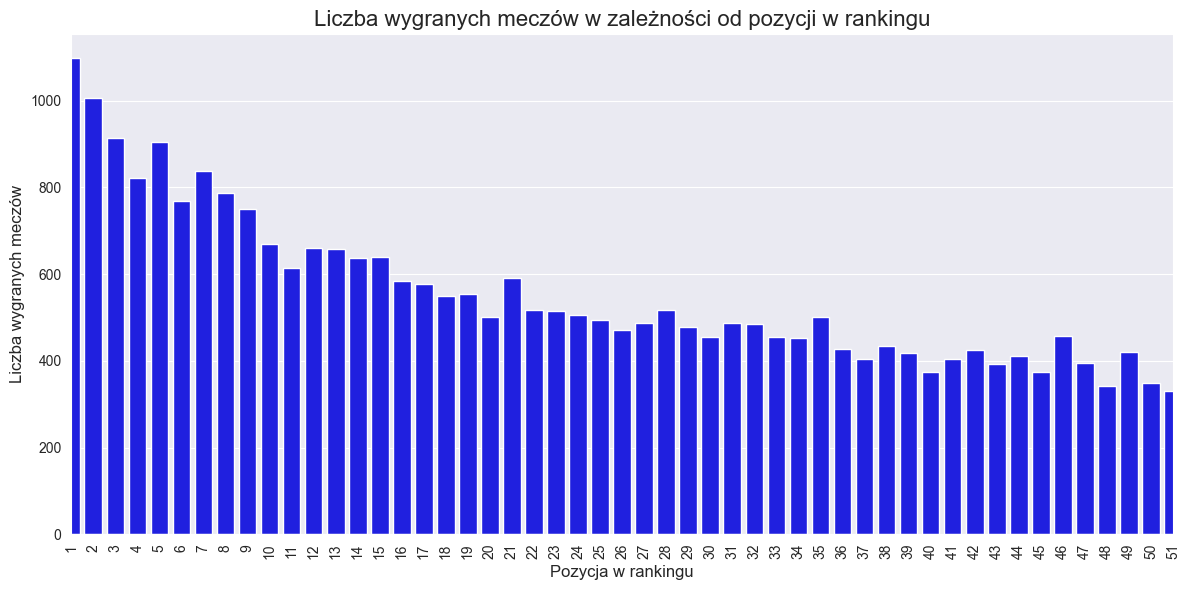

In [11]:
def rank_wins_plot(data):
    ranking_wins_1 = data[data['Winner'] == data['Player_1']].groupby("Rank_1").size().reset_index(
        name="Wins").sort_values(
        by='Rank_1').rename(columns={"Rank_1": "Rank"})
    ranking_wins_2 = data[data['Winner'] == data['Player_2']].groupby("Rank_2").size().reset_index(
        name="Wins").sort_values(
        by='Rank_2').rename(columns={"Rank_2": "Rank"})
    ranking_wins = pd.concat([ranking_wins_1, ranking_wins_2])
    ranking_wins = ranking_wins.groupby("Rank")['Wins'].sum().reset_index().sort_values(by='Rank')
    # print(ranking_wins)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Rank', y='Wins', data=ranking_wins, color='blue')
    plt.title('Liczba wygranych meczów w zależności od pozycji w rankingu', fontsize=16)
    plt.xlabel('Pozycja w rankingu', fontsize=12)
    plt.ylabel('Liczba wygranych meczów', fontsize=12)
    plt.xticks(rotation=90)
    plt.xlim(0, 50)
    plt.tight_layout()
    plt.show()
rank_wins_plot(data)

Następnie możemy zobaczyć jak zawodnicy radzą sobie na turniejach różnej kategorii wyliczając procent wygranych meczów. Zaczniemy od turniejów Wielkoszlemowych i przejdziemy aż do ATP 250.

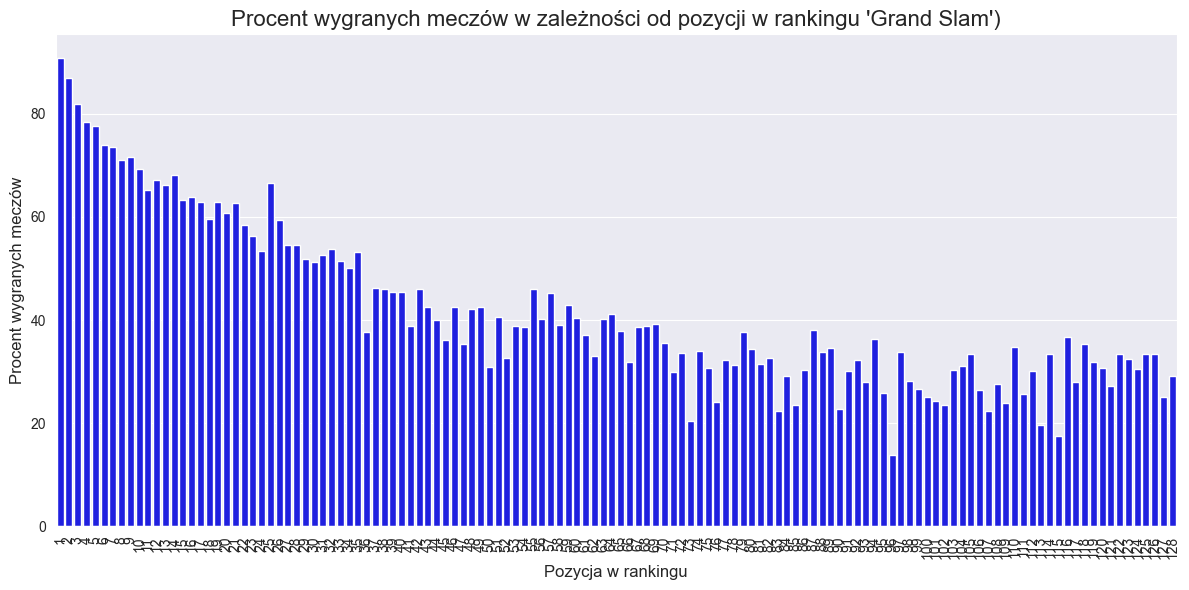

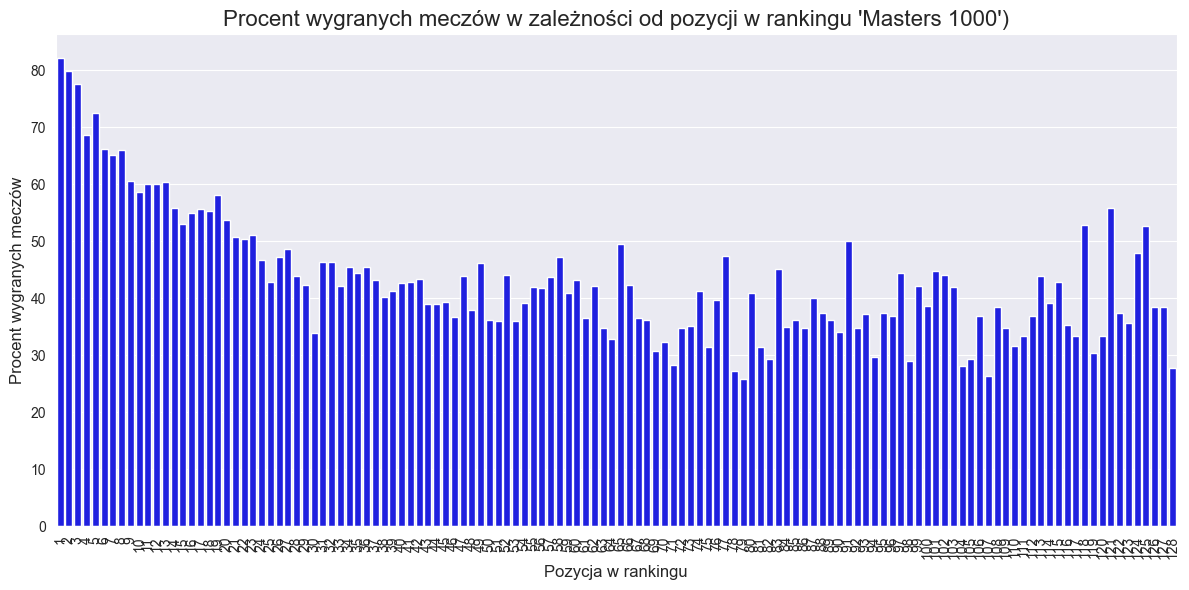

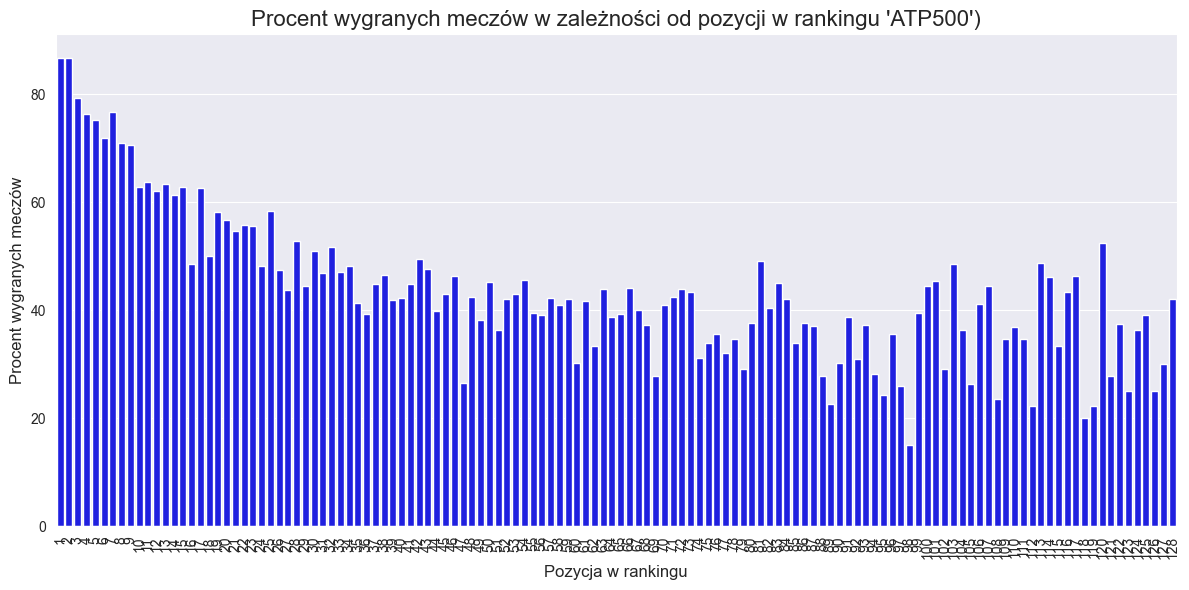

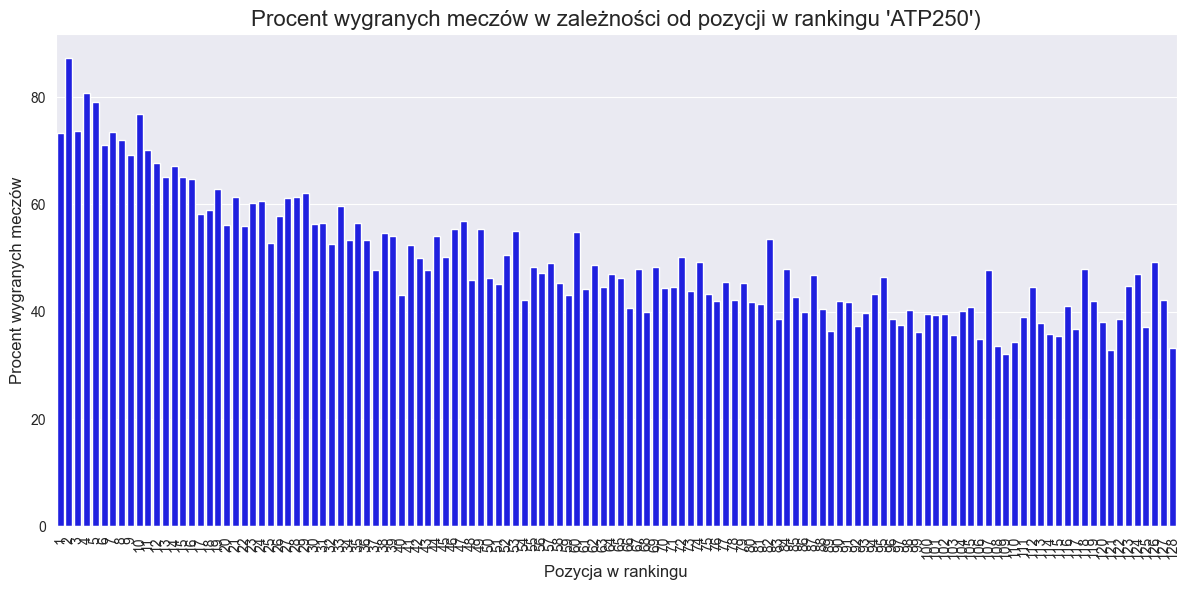

In [19]:
def rank_wins_tournament_plot(conn,tournament_type):
    # tutaj zmieniamy tylko serie turnieju do filtra
    query = f"SELECT * FROM matches where Series = '{tournament_type}' and Rank_1 < 129 and Rank_2 < 129"
    data = pd.read_sql_query(query, conn)
    ranking_wins_1 = data[data['Winner'] == data['Player_1']].groupby("Rank_1").size().reset_index(
        name="Wins").sort_values(
        by='Rank_1').rename(columns={"Rank_1": "Rank"})
    ranking_wins_2 = data[data['Winner'] == data['Player_2']].groupby("Rank_2").size().reset_index(
        name="Wins").sort_values(
        by='Rank_2').rename(columns={"Rank_2": "Rank"})
    ranking_wins = pd.concat([ranking_wins_1, ranking_wins_2])
    ranking_wins = ranking_wins.groupby("Rank")['Wins'].sum().reset_index().sort_values(by='Rank')

    matches_played_1 = data.groupby("Rank_1").size().reset_index(name='Matches_played').rename(
        columns={"Rank_1": "Rank"})
    matches_played_2 = data.groupby("Rank_2").size().reset_index(name='Matches_played').rename(
        columns={"Rank_2": "Rank"})
    matches_played = pd.concat([matches_played_1, matches_played_2])
    matches_played = matches_played.groupby('Rank')['Matches_played'].sum().reset_index().sort_values(by='Rank')

    win_percentage = pd.merge(matches_played, ranking_wins, on="Rank", how='left')
    win_percentage['Win_Percentage'] = (win_percentage["Wins"] / win_percentage['Matches_played']) * 100

    # print(win_percentage)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Rank', y='Win_Percentage', data=win_percentage, color='blue')
    # Dodanie tytułu i etykiet osi
    plt.title(f"Procent wygranych meczów w zależności od pozycji w rankingu '{tournament_type}')", fontsize=16)
    plt.xlabel('Pozycja w rankingu', fontsize=12)
    plt.ylabel('Procent wygranych meczów', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
rank_wins_tournament_plot(conn, 'Grand Slam')
rank_wins_tournament_plot(conn, 'Masters 1000')
rank_wins_tournament_plot(conn, 'ATP500')
rank_wins_tournament_plot(conn, 'ATP250')

Można zauważyć, że ze spadkiem rangi turnieju wykres wygranych delikatnie się wyrównuje, co może nam sugerować, że topowi zawodnicy pomimo tego, że dalej mają największą skuteczność "odpuszczają" mniejsze, mniej znaczące turnieje zachowując siły na największe imprezy.

Zakładając na chwilę turniejów możemy zrobić jeszcze jeden wykres zależności pozycji w rankingu do procentu wygranych meczy.

In [ ]:
def ranking_bins_win_percentage(data):
    data['Rank_Difference'] = abs(data['Rank_1'] - data['Rank_2'])
    data['Odds_Difference'] = abs(data['Odd_1'] - data['Odd_2'])
    data['Winner_Label'] = (data['Winner'] == data['Player_1']).astype(int)
    data['Rank_Bin'] = pd.cut(data['Rank_1'], bins=[0, 10, 20, 50, 100, float('inf')],
                              labels=['Top 10', 'Top 20', 'Top 50', 'Top 100', '>100'])

    rank_win_percentage = data.groupby('Rank_Bin')['Winner_Label'].mean() * 100
    # print(rank_win_percentage)
    rank_win_percentage.plot(kind='bar', color='blue', figsize=(10, 6),
                             title='Procent wygranych według pozycji w rankingu')
    plt.xlabel('Pozycja w rankingu')
    plt.ylabel('Procent wygranych (%)')
    plt.tight_layout()
    plt.show()
ranking_bins_win_percentage(data)

## 3.2. Jak różnica w rankingu wpływa na wynik spotkania
Kolejna z pozoru oczywista zależność, która po sprawdzeniu pokazuje nieoczywiste dane. Wydawać by się mogło, że jeśli zestawimy ze sobą zawodników których różni 50 lub nawet 100 oczek rankingowych wynik powinien być z góry przesądzony. Jednak jak sprawdzimy dane częstotliwości wygrywania meczy zawodników o niższym rankingu, okazuje się, że dane niewiele się różnią dla zbliżonych pozycji rankingowych względem tych bardziej odległych. 

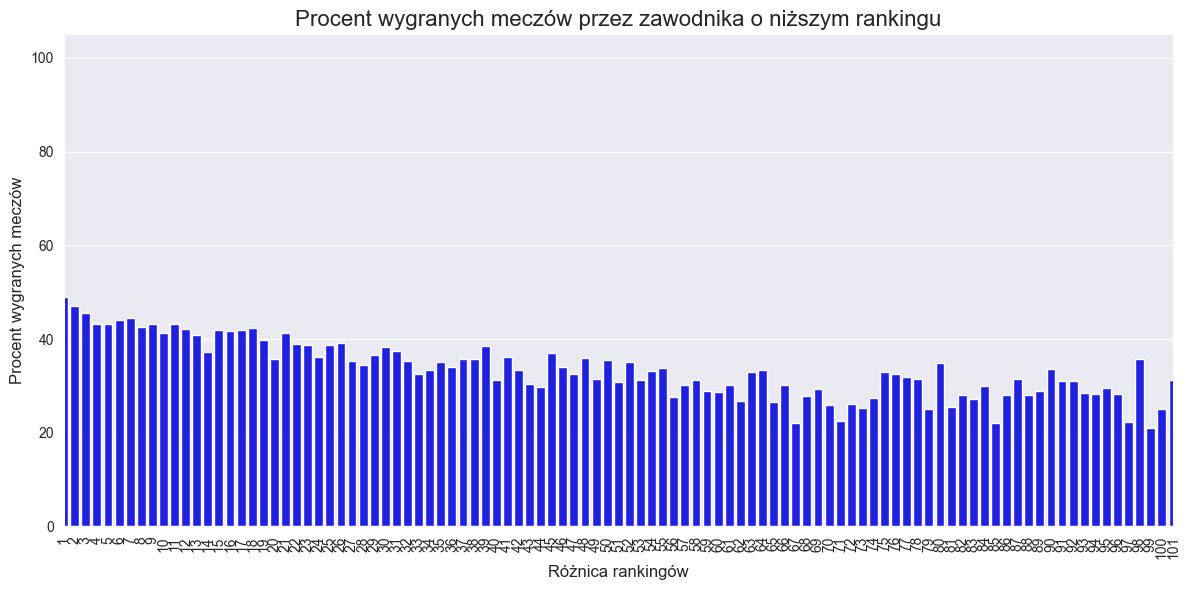

In [20]:
def ranking_difference_percentage(data):
    data["Ranking_Difference"] = abs(data["Rank_1"] - data["Rank_2"])
    all_matches = data.groupby("Ranking_Difference").size().reset_index(name="All")

    low_win_1 = data[(data["Winner"] == data["Player_1"]) & (data["Rank_1"] > data["Rank_2"])]
    low_win_2 = data[(data["Winner"] == data["Player_2"]) & (data["Rank_1"] < data["Rank_2"])]
    low_win = pd.concat([low_win_1, low_win_2])

    low_win = low_win.groupby("Ranking_Difference").size().reset_index(name="Wins")

    win_percentage = pd.merge(all_matches, low_win, on="Ranking_Difference", how="left")
    win_percentage["win_percentage"] = (win_percentage["Wins"] / win_percentage["All"]) * 100
    win_percentage = win_percentage.dropna()
    # print(win_percentage.to_string())
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Ranking_Difference', y='win_percentage', data=win_percentage, color='blue')
    plt.title('Procent wygranych meczów przez zawodnika o niższym rankingu', fontsize=16)
    plt.xlabel('Różnica rankingów', fontsize=12)
    plt.ylabel('Procent wygranych meczów', fontsize=12)
    plt.xticks(rotation=90)
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()
ranking_difference_percentage(data)


## 3.3. Poprawność kursów bookmacherów:
Kolejną rzeczą, jaką możemy sprawdzić w ramach analizy eksploracyjnej, jest zbadanie, jak różnica wartości kursów oceniana przez bookmacherów wpływa na rzeczywisty wynik spotkania, innymi słowy jak często mają oni rację i kiedy się mylą.

C:\Users\Grzesiu\AppData\Local\Temp\ipykernel_26156\1530316538.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_matches = data.groupby('odds_difference_bins').size().reset_index(name="All")
C:\Users\Grzesiu\AppData\Local\Temp\ipykernel_26156\1530316538.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  low_win = low_win.groupby("odds_difference_bins").size().reset_index(name="Wins")


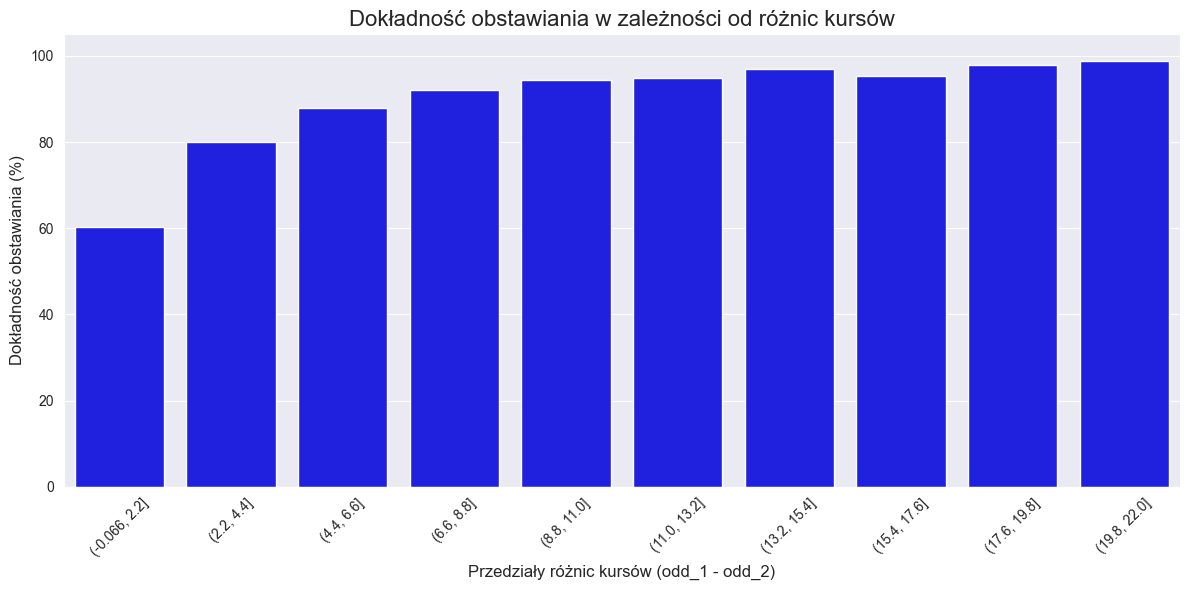

In [32]:
def prematch_odds_accuracy(data,bin_no):
    data["odds_difference"] = abs(data['Odd_1'] - data['Odd_2'])

    data["odds_difference_bins"] = pd.cut(data['odds_difference'], bins=bin_no)

    all_matches = data.groupby('odds_difference_bins').size().reset_index(name="All")
    low_win_1 = data[(data['Winner'] == data['Player_1']) & (data['Odd_1'] < data['Odd_2'])]
    low_win_2 = data[(data['Winner'] == data['Player_2']) & (data['Odd_1'] > data['Odd_2'])]
    low_win = pd.concat([low_win_1, low_win_2])
    low_win = low_win.groupby("odds_difference_bins").size().reset_index(name="Wins")

    accuracy = pd.merge(all_matches, low_win, on="odds_difference_bins", how="left")
    accuracy["percentage"] = (accuracy['Wins']/accuracy['All'])*100
    # print(accuracy.to_string())
    plt.figure(figsize=(12, 6))
    sns.barplot(x='odds_difference_bins', y="percentage", data=accuracy, color='blue')
    plt.title('Dokładność obstawiania w zależności od różnic kursów', fontsize=16)
    plt.xlabel('Przedziały różnic kursów (odd_1 - odd_2)', fontsize=12)
    plt.ylabel('Dokładność obstawiania (%)', fontsize=12)
    plt.xticks(rotation=45)
    # wyświetlamy tylko kilka pierwszych, kolejne prawie wszystkie dobijają do 100% (z drobnymi pomijalnymi wyjątkami)
    plt.xlim(-0.5, 9.5)
    plt.margins(x=0.02)
    plt.tight_layout()
    plt.show()
prematch_odds_accuracy(data,30)

In [ ]:
Jak łatwo zauważyć dla wysokich różnic kursów bookmacherzy są niemal bezbłędni w ocenie. Oczywiście jak to w sporcie zdarzają się wyjątki jednak są to pojedyncze przypadki które można pominąć w analizie całości. Dla przykładu tego typu wyjątki występują między innymi pod indeksem 11,12 i 15                                                         odds_difference_bins    All      Wins   percentage                                                                                                      0         (-0.066, 2.2]     30970   18632   60.161447                                                                                                      1            (2.2, 4.4]     10671   8539    80.020617
                                        2            (4.4, 6.6]     2754    2420    87.872186
                                        3            (6.6, 8.8]     1331    1227    92.186326
                                        4           (8.8, 11.0]     1052    993     94.391635
                                        5          (11.0, 13.2]     368     349     94.836957
                                        6          (13.2, 15.4]     368     357     97.010870
                                        7          (15.4, 17.6]     192     183     95.312500
                                        8          (17.6, 19.8]     144     141     97.916667
                                        9          (19.8, 22.0]     234     231     98.717949
                                        ...
                                        11         (24.2, 26.4]     106     105     99.056604
                                        12         (26.4, 28.6]     50      42      84.000000
                                        ...
                                        ...
                                        15         (33.0, 35.2]     2       1       50.0000000

Dla wysokich różnic w kursach widać, że szacowania są zgodne w niemal 100%. Sprawdźmy co się dzieje dla mniejszych wartości 

C:\Users\Grzesiu\AppData\Local\Temp\ipykernel_26156\1530316538.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_matches = data.groupby('odds_difference_bins').size().reset_index(name="All")
C:\Users\Grzesiu\AppData\Local\Temp\ipykernel_26156\1530316538.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  low_win = low_win.groupby("odds_difference_bins").size().reset_index(name="Wins")


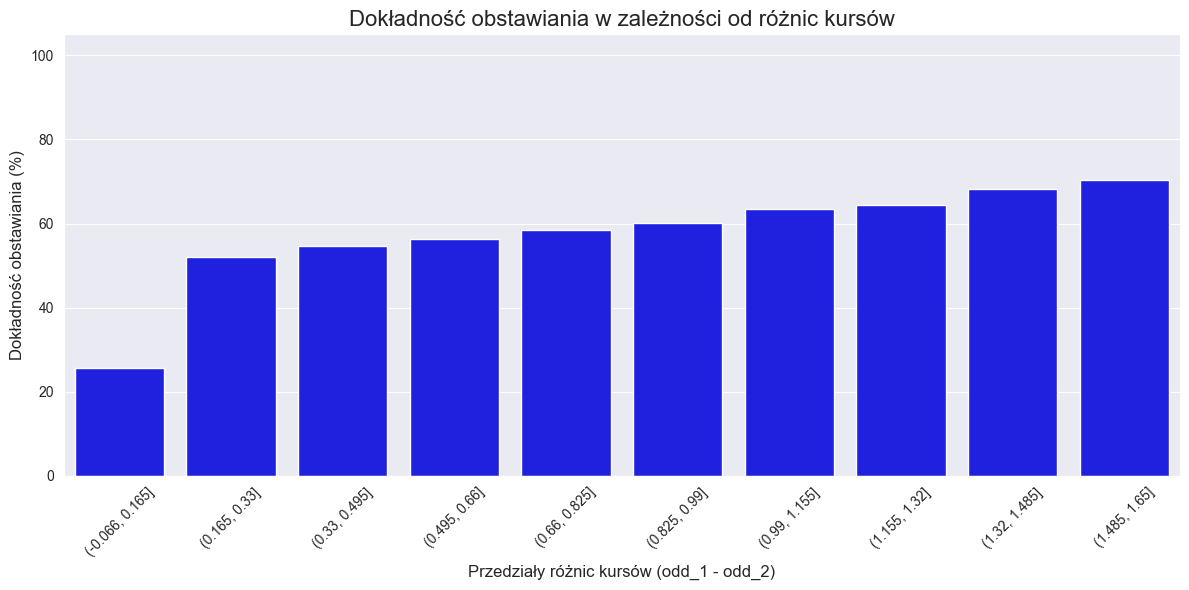

In [33]:
prematch_odds_accuracy(data, 400)

Łatwo zauważyć, że im mniejsza wartość różnicy kursu tym gorsze są przewidywania. Biorąc pod uwagę to, że zdecydowana większość obstawień zawiera się w tych przedziałach możemy wywnioskować, że różnica kursów w ogólnym przypadku nie jest najlepszym predyktorem.

# 4. Opracowanie modelu statystycznego:
Najpierw dodajmy kolumny niezbędne do dalszych analiz.

In [35]:
data['Rank_Difference'] = abs(data['Rank_1'] - data['Rank_2'])
data['Odds_Difference'] = abs(data['Odd_1'] - data['Odd_2'])
data['Winner_Label'] = (data['Winner'] == data['Player_1']).astype(int)

## 4.1. Random Forest - przewidywanie zwycięzcy
Z wykorzystaniem algorytmu z biblioteki RandomForest jesteśmy w stanie sprawdzić istotność danych cech do przewidywania zwycięzcy danego meczu.

Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      4879
           1       0.66      0.66      0.66      4790

    accuracy                           0.66      9669
   macro avg       0.66      0.66      0.66      9669
weighted avg       0.66      0.66      0.66      9669


Confusion Matrix:
[[3213 1666]
 [1609 3181]]


C:\Users\Grzesiu\AppData\Local\Temp\ipykernel_26156\3887415616.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


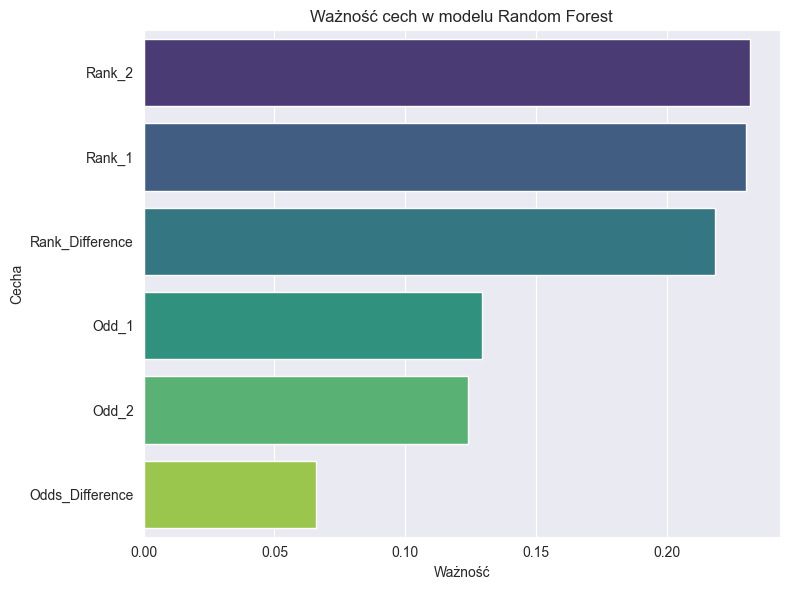

In [37]:
def random_forest():
    data['Rank_Difference'] = abs(data['Rank_1'] - data['Rank_2'])
    data['Odds_Difference'] = abs(data['Odd_1'] - data['Odd_2'])
    data['Winner_Label'] = (data['Winner'] == data['Player_1']).astype(int)
    data.dropna()
    X = data[['Rank_Difference', 'Rank_1', 'Rank_2', 'Odd_1', 'Odd_2', 'Odds_Difference']]
    y = data['Winner_Label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    # Ważność cech
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    # Wykres ważności cech
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
    plt.title('Ważność cech w modelu Random Forest')
    plt.xlabel('Ważność')
    plt.ylabel('Cecha')
    plt.tight_layout()
    plt.show()
random_forest()

Accuracy: 0.66

Wartość ta pokazuje, że mają tak proste dane, jak ranking i przewidywania jesteśmy w stanie wydedukować zwycięzcę danego meczu aż 2 na 3 razy. Nie jest nam do tego potrzebna analiza stylu gry danych zawodników, nawierzchni, na której rozgrywany jest turniej ani warunków atmosferycznych, które panują w danym dni i komu one bardziej sprzyjają. Wystarczy znać ranking i przeczytać obstawienia bookmacherów, żeby móc w większości przypadków wydedukować zwycięzcę.

## 4.2. Istotność cech w przewidywaniach wyniku meczu

Wykonajmy jeszcze 2 testy w celu sprawdzenia ważności zmiennych w analizie.

In [38]:
def test1(data):
    # Test dla różnicy rankingów
    rank_diff_winner = data[data['Winner_Label'] == 1]['Rank_Difference']
    rank_diff_loser = data[data['Winner_Label'] == 0]['Rank_Difference']

    t_stat_rank, p_value_rank = ttest_ind(rank_diff_winner, rank_diff_loser)
    print(f"Rank Difference: T-statistic = {t_stat_rank:.2f}, P-value = {p_value_rank:.4f}")

    # Test dla różnicy kursów
    odds_diff_winner = data[data['Winner_Label'] == 1]['Odds_Difference']
    odds_diff_loser = data[data['Winner_Label'] == 0]['Odds_Difference']

    t_stat_odds, p_value_odds = ttest_ind(odds_diff_winner, odds_diff_loser)
    print(f"Odds Difference: T-statistic = {t_stat_odds:.2f}, P-value = {p_value_odds:.4f}")
test1(data)

Rank Difference: T-statistic = -0.61, P-value = 0.5409
Odds Difference: T-statistic = -0.62, P-value = 0.5348


In [40]:
def chi_kwadrat(data):
    # Tworzenie kategorii dla różnicy kursów
    data['Odds_Bin'] = pd.cut(data['Odds_Difference'], bins=[0, 2, 4, 6, 8, 10, float('inf')],
                              labels=['0-2', '2-4', '4-6', '6-8', '8-10', '>10'])

    # Tworzenie tabeli kontyngencji
    contingency_table = pd.crosstab(data['Odds_Bin'], data['Winner_Label'])

    # Test chi-kwadrat
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared: {chi2:.2f}, P-value: {p:.4f}")
chi_kwadrat(data)

Chi-squared: 7.68, P-value: 0.1749


Sprawdziliśmy istotność różnic w rankingu i w kursach dla przewidywań zwycięzcy meczu. Jednak porównując te dane z wartościami, przy których mamy podstawy do odrzuceń hipotez zerowych, możemy stwierdzić, że wartości te nie mają istotnego wpływu na przewidywanie wyniku meczu. Porównując to z wynikiem, który otrzymaliśmy dzięki random forest, możemy stwierdzić, że większe znaczenie dla wyniku ma indywidualny ranking jednego bądź drugiego zawodnika niż różnica między tymi rankingami. Taka sama zależność tyczy się wartości kursów. 

## 4.3. Regresja

Sprawdzanie zależności zmiennych i ich wpływu na końcowy wynik.

Optimization terminated successfully.
         Current function value: 0.571689
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Winner_Label   No. Observations:                48344
Model:                          Logit   Df Residuals:                    48337
Method:                           MLE   Df Model:                            6
Date:                Mon, 30 Dec 2024   Pseudo R-squ.:                  0.1752
Time:                        15:31:46   Log-Likelihood:                -27638.
converged:                       True   LL-Null:                       -33510.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1477      0.178     -0.831      0.406      -0.496       0.201
Rank_Differenc

C:\Users\Grzesiu\AppData\Local\Temp\ipykernel_26156\1958345599.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')


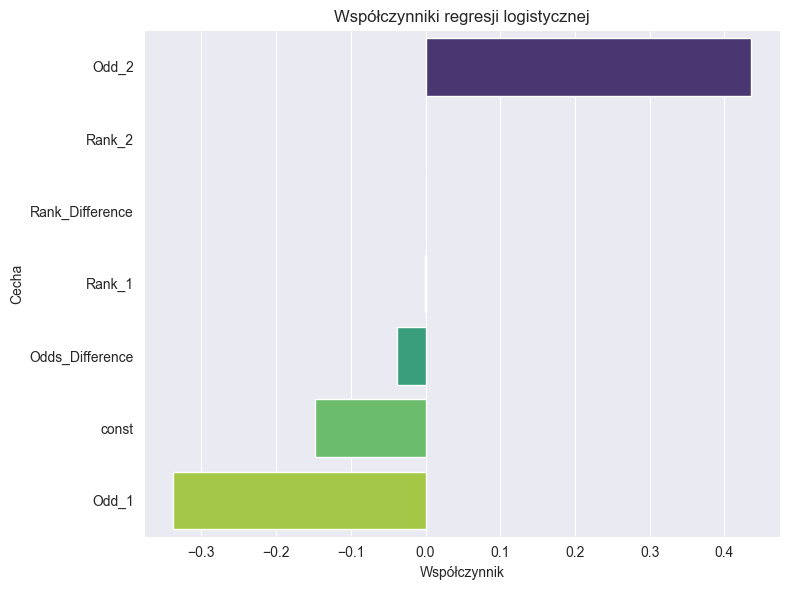

In [41]:
def regresja(data):
    # Dodanie stałej do modelu (wymagane przez statsmodels)
    X = sm.add_constant(data[['Rank_Difference', 'Rank_1', 'Rank_2', 'Odds_Difference', 'Odd_1', 'Odd_2']])
    y = data['Winner_Label']

    # Regresja liniowa
    model = sm.Logit(y, X).fit()
    print(model.summary())

    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.params
    }).sort_values(by='Coefficient', ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
    plt.title('Współczynniki regresji logistycznej')
    plt.xlabel('Współczynnik')
    plt.ylabel('Cecha')
    plt.tight_layout()
    plt.show()
regresja(data)

Analizując dane, potwierdzają się poprzednie wnioski o tym, że różnice rankingów i kursów nie mają na tyle istotnego wpływu na wynik jak te wartości same w sobie.

## 4.4. Weryfikacja hipotez statystycznych

Obserwując dane zawierające zależność między rankingiem a procentem wygranych pojedynków na turniejach różnego szczebla można była wysunąć hipotezę, że zawodnicy o wyższym rankingu "odpuszczają" mniejsze turnieje skupiając się jedynie na największych podczas całego touru. Poniżej znajduje się analiza tej hipotezy:


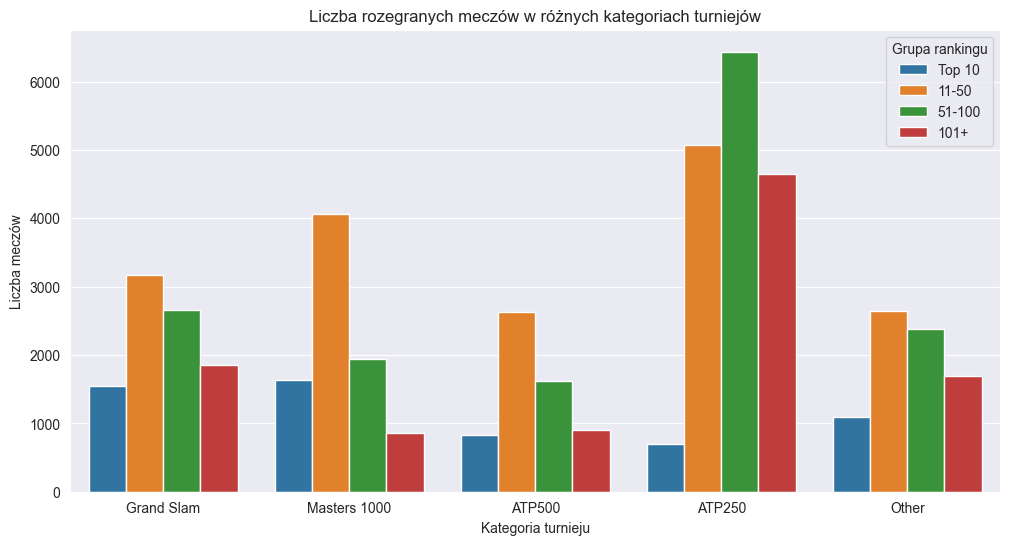

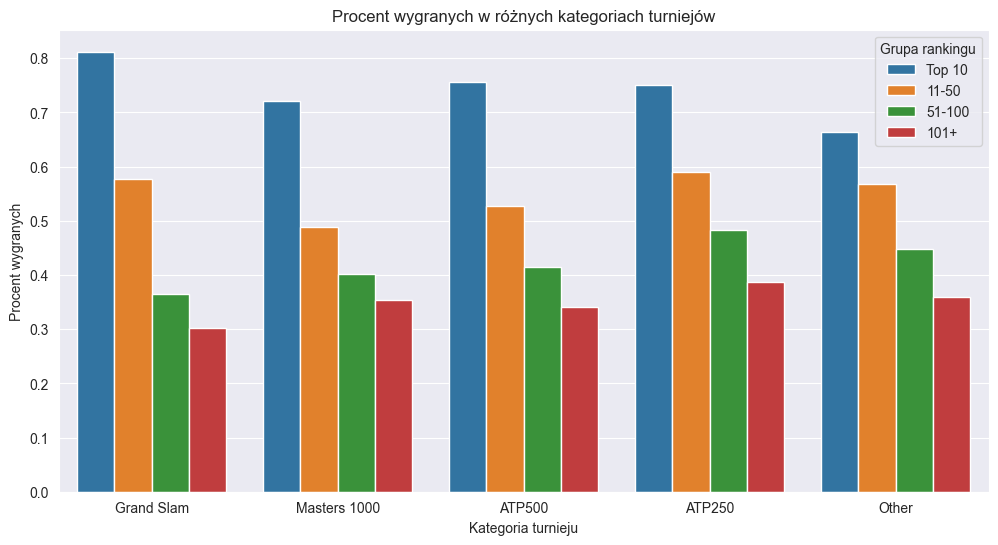

   Rank_Group Tournament_Category  Matches_Played  Win_Percentage
0        101+              ATP250            4642        0.387764
1        101+              ATP500             899        0.341491
2        101+          Grand Slam            1859        0.302313
3        101+        Masters 1000             852        0.353286
4        101+               Other            1697        0.360047
5       11-50              ATP250            5065        0.590523
6       11-50              ATP500            2629        0.526816
7       11-50          Grand Slam            3165        0.576619
8       11-50        Masters 1000            4059        0.488790
9       11-50               Other            2648        0.567976
10     51-100              ATP250            6436        0.482598
11     51-100              ATP500            1624        0.414409
12     51-100          Grand Slam            2657        0.365450
13     51-100        Masters 1000            1941        0.401340
14     51-

In [44]:
def weryfikacja_hipotez(data):
    def categorize_tournament(row):
        if "Grand Slam" in row['Series']:
            return "Grand Slam"
        elif "Masters 1000" in row['Series']:
            return "Masters 1000"
        elif "ATP500" in row['Series']:
            return "ATP500"
        elif "ATP250" in row['Series']:
            return "ATP250"
        else:
            return "Other"

    data['Tournament_Category'] = data.apply(categorize_tournament,axis=1)

    def rank_group(rank):
        if rank <= 10:
            return "Top 10"
        elif rank <= 50:
            return "11-50"
        elif rank <= 100:
            return "51-100"
        else:
            return "101+"

    data['Rank_Group'] = data['Rank_1'].apply(rank_group)

    matches_played = data.groupby(['Rank_Group', 'Tournament_Category']).size().reset_index(name='Matches_Played')

    data['Win_1'] = (data['Winner_Label'] == 1).astype(int)
    win_stats = data.groupby(['Rank_Group', 'Tournament_Category'])['Win_1'].mean().reset_index(name='Win_Percentage')

    stats = pd.merge(matches_played, win_stats, on=['Rank_Group', 'Tournament_Category'])

    plt.figure(figsize=(12, 6))
    tournament_order = ['Grand Slam', 'Masters 1000', 'ATP500', 'ATP250', 'Other']
    rank_group_order = ['Top 10', '11-50', '51-100', '101+']
    sns.barplot(data=matches_played, x='Tournament_Category', y='Matches_Played', hue='Rank_Group',order=tournament_order, hue_order=rank_group_order)
    plt.title('Liczba rozegranych meczów w różnych kategoriach turniejów')
    plt.xlabel('Kategoria turnieju')
    plt.ylabel('Liczba meczów')
    plt.legend(title='Grupa rankingu')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=win_stats, x='Tournament_Category', y='Win_Percentage', hue='Rank_Group',order=tournament_order, hue_order=rank_group_order)
    plt.title('Procent wygranych w różnych kategoriach turniejów')
    plt.xlabel('Kategoria turnieju')
    plt.ylabel('Procent wygranych')
    plt.legend(title='Grupa rankingu')
    plt.show()

    print(stats)
weryfikacja_hipotez(data)

Widać, że najlepsi zawodnicy mają najlepiej wyśróbowane statystyki właśnie na tych prestiżowych, ważnych turniejach. Turnieje te są też przez nich najczęściej wybierane, ilość wystąpień zawodników z top 10 w turniejach wielkoszlemowych a w turniejach rangi masters 1000 które są drugą największą kategorią tenisowych rozgrywek są praktycznie identyczne (odpowiednio 1543 i 1629 rozegranych meczy). Biorąc pod uwagę ilość turniejów w trakcie roku (4 turnieje wielkoszlemowe i 9 turniejów Masters 1000) możemy śmiało stwierdzić jakie są priorytety danych zawodników i na które są najlepiej przygotowani.

# 5. Zakończenie

Chodź wybrane przeze mnie dane oraz zależności między nimi są dość oczywiste, to udało się zaobserwować kilka ciekawych rzeczy. Oraz stworzyć prosty model probabilistyczny pozwalający nam w większości przypadków oszacować zwycięzcę danego meczu.

In [ ]:
conn.close()